In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from skrebate import ReliefF
from sklearn.linear_model import Lasso



In [3]:
# Load the dataset
df = pd.read_csv('Cardiovascular_Disease_Dataset.csv')


In [4]:
# Understanding the data
df.head()

,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientid          1000 non-null   int64  
 1   age                1000 non-null   int64  
 2   gender             1000 non-null   int64  
 3   chestpain          1000 non-null   int64  
 4   restingBP          1000 non-null   int64  
 5   serumcholestrol    1000 non-null   int64  
 6   fastingbloodsugar  1000 non-null   int64  
 7   restingrelectro    1000 non-null   int64  
 8   maxheartrate       1000 non-null   int64  
 9   exerciseangia      1000 non-null   int64  
 10  oldpeak            1000 non-null   float64
 11  slope              1000 non-null   int64  
 12  noofmajorvessels   1000 non-null   int64  
 13  target             1000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 109.5 KB


In [6]:
df.shape

(1000, 14)

<Axes: xlabel='target', ylabel='count'>

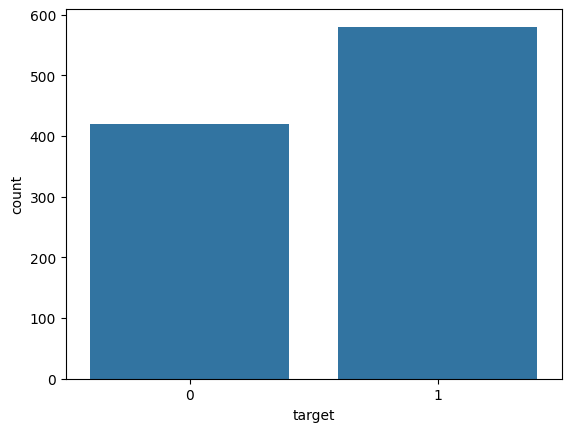

In [7]:
df['target'].value_counts()
sb.countplot(x='target', data=df)

In [8]:
# Separate features and target
X = df.drop(['target', 'patientid'], axis=1)
y = df['target'].values  # Convert to numpy array

In [9]:
# Check for missing values
print(df.isnull().sum())  # Check for missing values
df.dropna(inplace=True)   # Drop missing values if any

patientid            0
age                  0
gender               0
chestpain            0
restingBP            0
serumcholestrol      0
fastingbloodsugar    0
restingrelectro      0
maxheartrate         0
exerciseangia        0
oldpeak              0
slope                0
noofmajorvessels     0
target               0
dtype: int64


In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Reset indices
X_train.reset_index(drop=True, inplace=True)
y_train = pd.Series(y_train).reset_index(drop=True)  # Reset index for y_train
print(X_train.columns.tolist())  # This will show the exact feature names used during training



['age', 'gender', 'chestpain', 'restingBP', 'serumcholestrol', 'fastingbloodsugar', 'restingrelectro', 'maxheartrate', 'exerciseangia', 'oldpeak', 'slope', 'noofmajorvessels']


In [12]:
# Standardize the features
import os
import pickle
from sklearn.preprocessing import StandardScaler

# Create the directory if it doesn't exist
model_dir = "models/trained_models"
os.makedirs(model_dir, exist_ok=True)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save fitted scaler
scaler_path = os.path.join(model_dir, "scaler.pkl")
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

print(f"Scaler saved successfully at {scaler_path}")


Scaler saved successfully at models/trained_models/scaler.pkl


In [13]:
from skrebate import ReliefF

# Initialize ReliefF with the desired number of features
num_features = 10  # Adjust based on experimentation
relief = ReliefF(n_features_to_select=num_features, n_neighbors=5)

# Fit ReliefF on training data
relief.fit(X_train_scaled, y_train)

# Get selected feature indices
selected_feature_indices = relief.top_features_[:num_features]

# Apply selected features
X_train_relief = X_train_scaled[:, selected_feature_indices]
X_test_relief = X_test_scaled[:, selected_feature_indices]

# Get selected feature names (useful for debugging)
selected_feature_names = X.columns[selected_feature_indices]

with open("models/trained_models/relief_features.pkl", "wb") as f:
    pickle.dump(selected_feature_names.tolist(), f)
print(f"Selected features by ReliefF: {list(selected_feature_names)}")



Selected features by ReliefF: ['slope', 'restingBP', 'noofmajorvessels', 'chestpain', 'serumcholestrol', 'restingrelectro', 'oldpeak', 'gender', 'maxheartrate', 'fastingbloodsugar']


In [14]:
# LASSO Feature Selection
from sklearn.linear_model import LassoCV

lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)
lasso.fit(X_train_scaled, y_train)

# Get non-zero coefficient features
lasso_coef = lasso.coef_  # This is a NumPy array
selected_feature_indices = np.where(lasso_coef != 0)[0]  # Get index positions

# Filter only selected features
X_train_lasso = X_train_scaled[:, selected_feature_indices]
X_test_lasso = X_test_scaled[:, selected_feature_indices]

# Get selected feature names (useful for debugging)
selected_feature_names = X.columns[selected_feature_indices]
with open("models/trained_models/lasso_features.pkl", "wb") as f:
    pickle.dump(selected_feature_names.tolist(), f)

print(f"Selected features by LASSO: {list(selected_feature_names)}")


Selected features by LASSO: ['age', 'gender', 'chestpain', 'restingBP', 'serumcholestrol', 'fastingbloodsugar', 'restingrelectro', 'maxheartrate', 'oldpeak', 'slope', 'noofmajorvessels']


In [15]:
# Define each model individually
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier()
adaboost = AdaBoostClassifier()
gradient_boosting = GradientBoostingClassifier()


In [16]:
# Function to train and evaluate models
import pickle
def evaluate_model(model, X_train, X_test, y_train, y_test,feature_selection="None"):
    model.fit(X_train, y_train)
     # This will show the exact feature names used during training

    model_filename = f"{model.__class__.__name__}_{feature_selection}.pkl"
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test , y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.savefig(f'Confusion_Matrix_{model.__class__.__name__}.svg', format='svg', bbox_inches='tight')
    plt.show()
    return accuracy, report, y_pred
    

In [17]:
model_accuracies = []
model_accuracies_relief = []
model_accuracies_lasso = []


Decision Tree
Without Feature Selection:


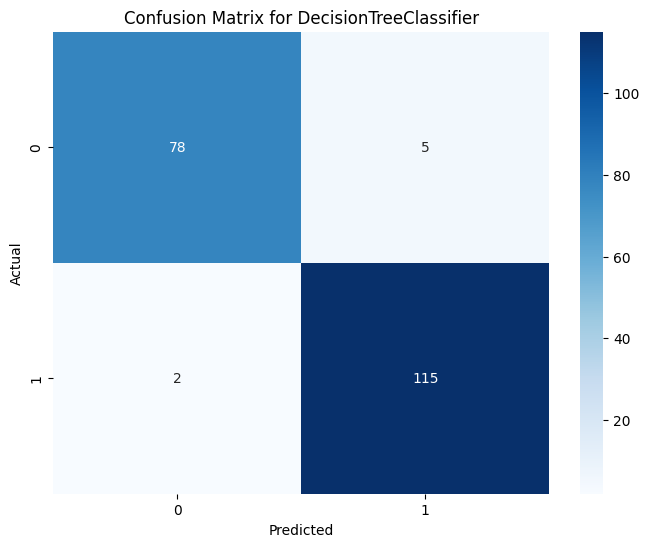

Accuracy: 0.9650
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        83
           1       0.96      0.98      0.97       117

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200


With Relief Feature Selection:


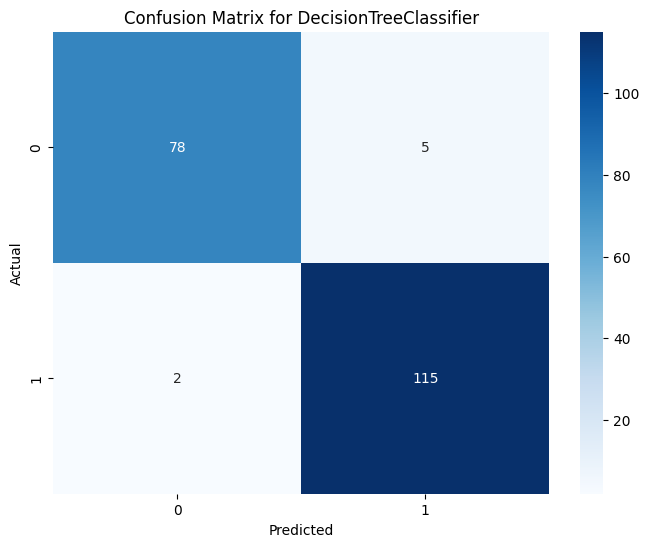

Accuracy: 0.9650
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        83
           1       0.96      0.98      0.97       117

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200


With LASSO Feature Selection:


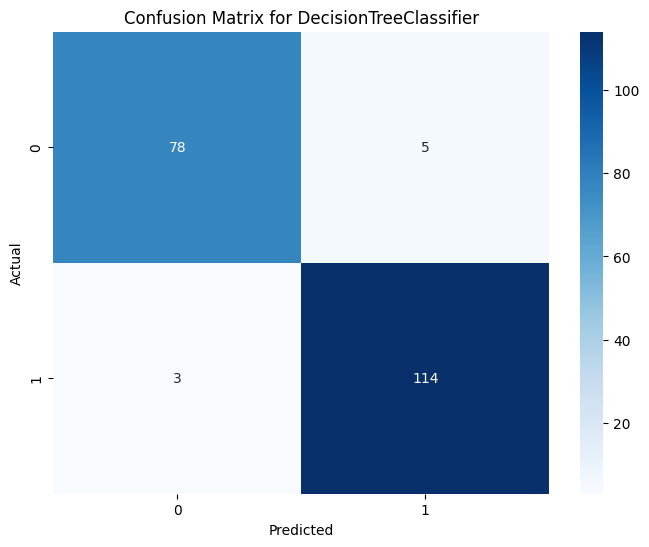

Accuracy: 0.9600
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        83
           1       0.96      0.97      0.97       117

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



In [18]:
# Evaluate Decision Tree
print("\nDecision Tree")
print("Without Feature Selection:")
accuracy, report, _ = evaluate_model(decision_tree, X_train_scaled, X_test_scaled, y_train, y_test,"NoFS")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies.append(("Decision Tree", accuracy))
print(report)

print("\nWith Relief Feature Selection:")
accuracy, report, _ = evaluate_model(decision_tree, X_train_relief, X_test_relief, y_train, y_test,"Relief")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_relief.append(("Decision Tree", accuracy))
print(report)

print("\nWith LASSO Feature Selection:")
accuracy, report, _ = evaluate_model(decision_tree, X_train_lasso, X_test_lasso, y_train, y_test,"LASSO")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_lasso.append(("Decision Tree", accuracy))
print(report)


Random Forest
Without Feature Selection:


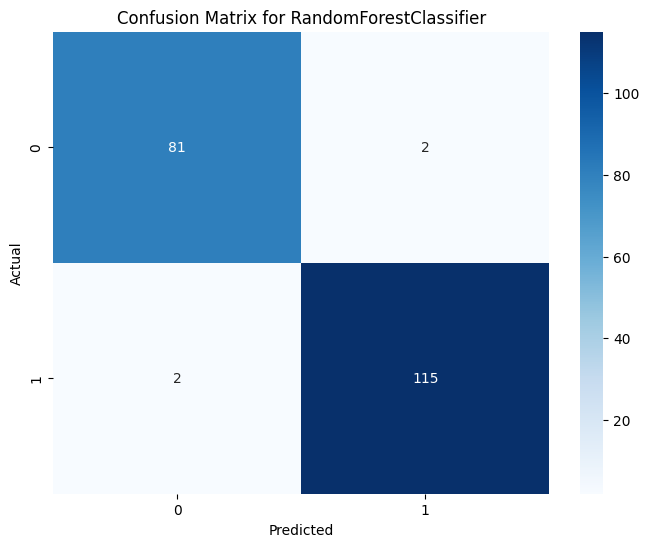

Accuracy: 0.9800
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        83
           1       0.98      0.98      0.98       117

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200


With Relief Feature Selection:


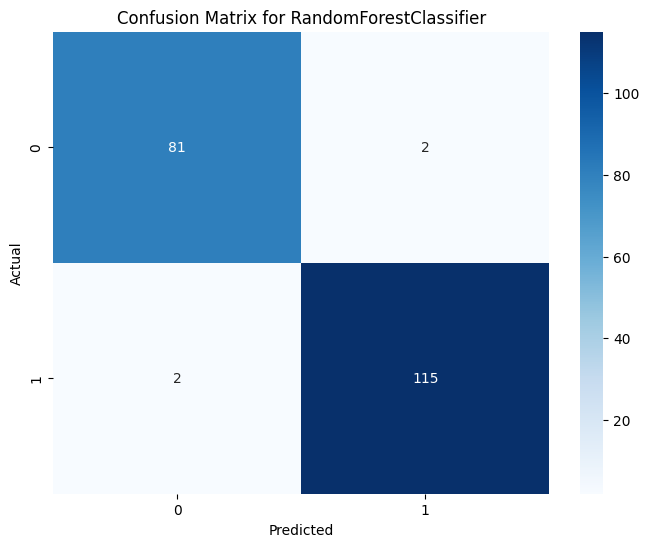

Accuracy: 0.9800
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        83
           1       0.98      0.98      0.98       117

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200


With LASSO Feature Selection:


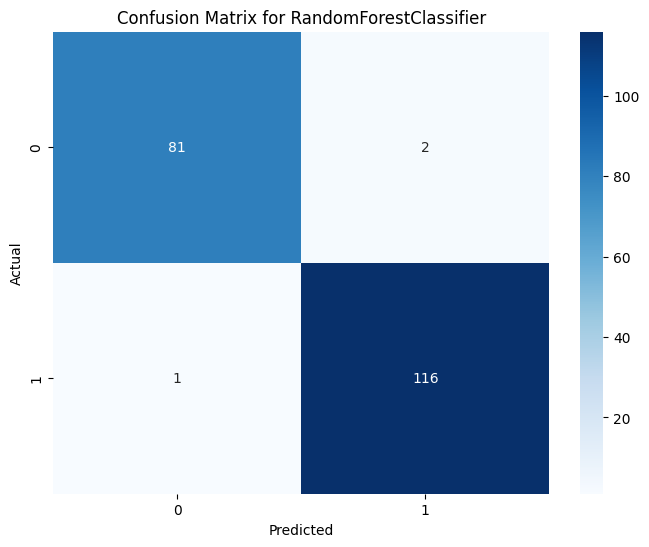

Accuracy: 0.9850
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        83
           1       0.98      0.99      0.99       117

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



In [19]:
# Evaluate Random Forest
print("\nRandom Forest")
print("Without Feature Selection:")
accuracy, report, _ = evaluate_model(random_forest, X_train_scaled, X_test_scaled, y_train, y_test,"NoFS")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies.append(("Random Forest", accuracy))
print(report)

print("\nWith Relief Feature Selection:")
accuracy, report, _ = evaluate_model(random_forest, X_train_relief, X_test_relief, y_train, y_test,"Relief")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_relief.append(("Random Forest", accuracy))
print(report)

print("\nWith LASSO Feature Selection:")
accuracy, report, _ = evaluate_model(random_forest, X_train_lasso, X_test_lasso, y_train, y_test,"LASSO")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_lasso.append(("Random Forest", accuracy))
print(report)


K-Nearest Neighbors
Without Feature Selection:


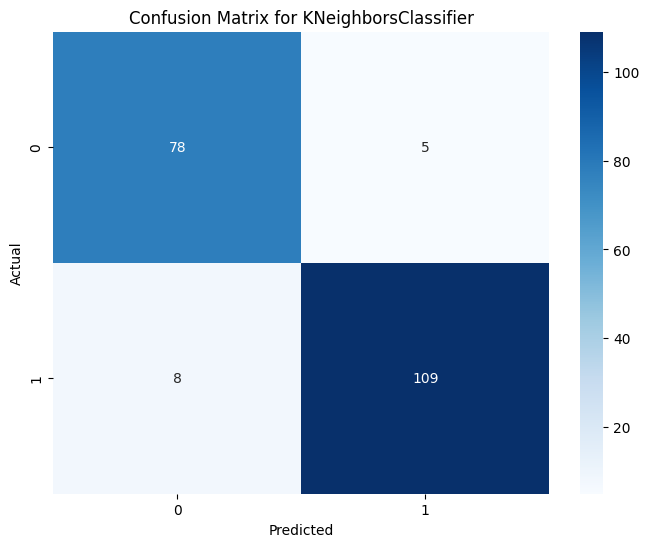

Accuracy: 0.9350
              precision    recall  f1-score   support

           0       0.91      0.94      0.92        83
           1       0.96      0.93      0.94       117

    accuracy                           0.94       200
   macro avg       0.93      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200


With Relief Feature Selection:


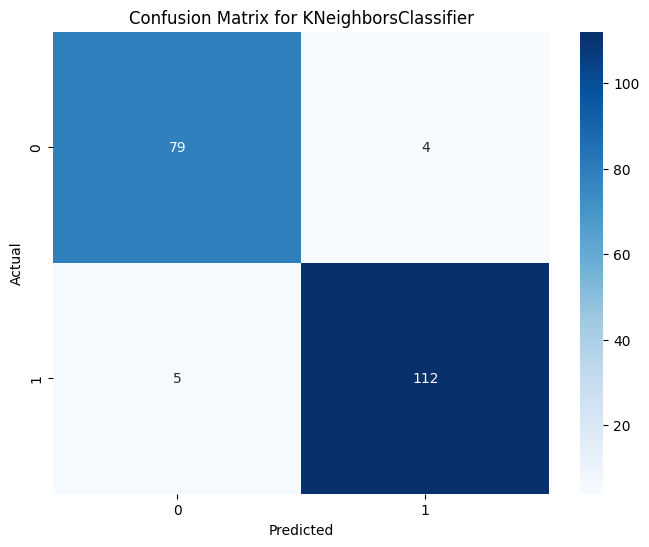

Accuracy: 0.9550
              precision    recall  f1-score   support

           0       0.94      0.95      0.95        83
           1       0.97      0.96      0.96       117

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.96      0.95      0.96       200


With LASSO Feature Selection:


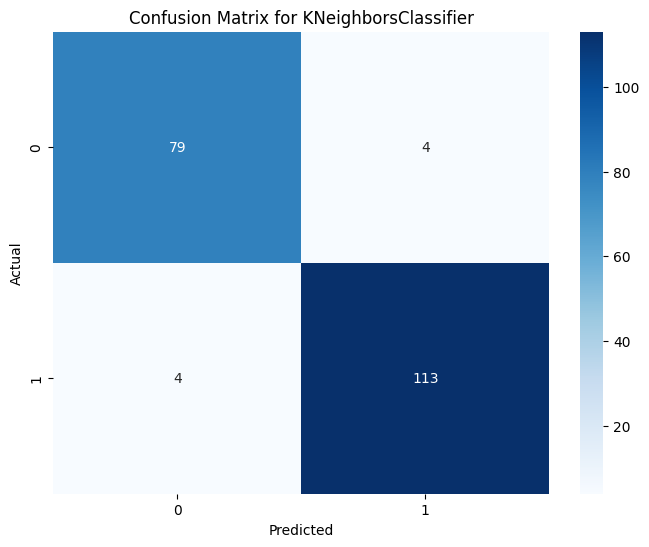

Accuracy: 0.9600
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        83
           1       0.97      0.97      0.97       117

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



In [20]:
# Evaluate K-Nearest Neighbors
print("\nK-Nearest Neighbors")
print("Without Feature Selection:")
accuracy, report, _ = evaluate_model(knn, X_train_scaled, X_test_scaled, y_train, y_test,"NoFS")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies.append(("K-Nearest Neighbors", accuracy))
print(report)

print("\nWith Relief Feature Selection:")
accuracy, report, _ = evaluate_model(knn, X_train_relief, X_test_relief, y_train, y_test,"Relief")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_relief.append(("K-Nearest Neighbors", accuracy))
print(report)

print("\nWith LASSO Feature Selection:")
accuracy, report, _ = evaluate_model(knn, X_train_lasso, X_test_lasso, y_train, y_test,"LASSO")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_lasso.append(("K-Nearest Neighbors", accuracy))
print(report)


AdaBoost
Without Feature Selection:


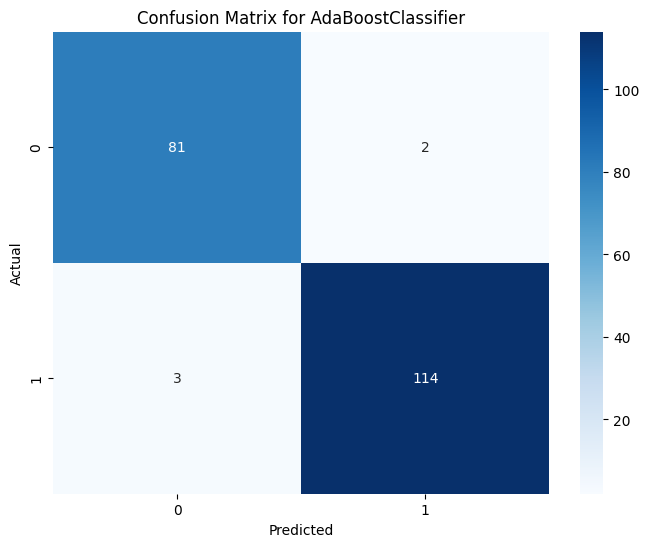

Accuracy: 0.9750
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        83
           1       0.98      0.97      0.98       117

    accuracy                           0.97       200
   macro avg       0.97      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200


With Relief Feature Selection:


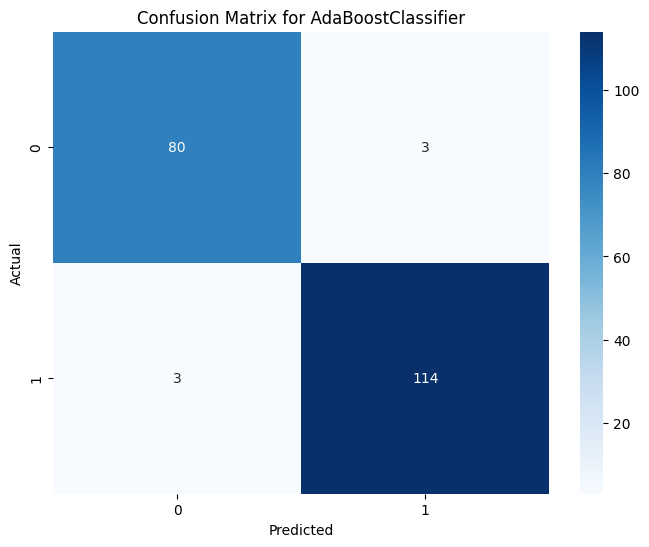

Accuracy: 0.9700
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        83
           1       0.97      0.97      0.97       117

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200


With LASSO Feature Selection:


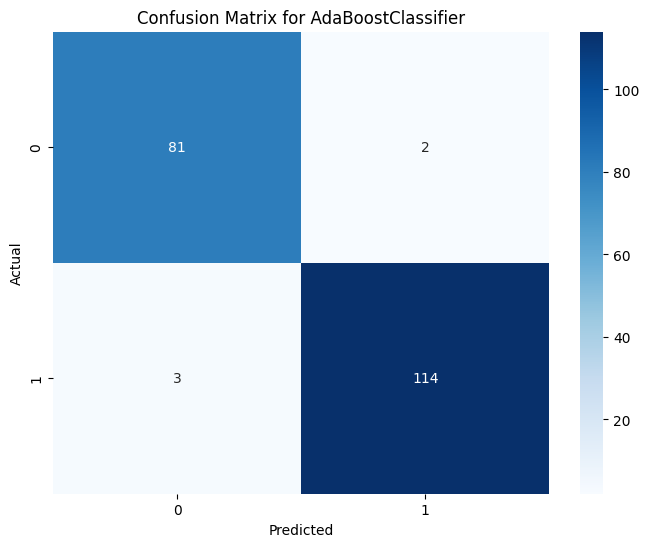

Accuracy: 0.9750
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        83
           1       0.98      0.97      0.98       117

    accuracy                           0.97       200
   macro avg       0.97      0.98      0.97       200
weighted avg       0.98      0.97      0.98       200



In [21]:
# Evaluate AdaBoost
print("\nAdaBoost")
print("Without Feature Selection:")
accuracy, report, _ = evaluate_model(adaboost, X_train_scaled, X_test_scaled, y_train, y_test,"NoFS")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies.append(("AdaBoost", accuracy))
print(report)

print("\nWith Relief Feature Selection:")
accuracy, report, _ = evaluate_model(adaboost, X_train_relief, X_test_relief, y_train, y_test,"Relief")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_relief.append(("AdaBoost", accuracy))
print(report)

print("\nWith LASSO Feature Selection:")
accuracy, report, _ = evaluate_model(adaboost, X_train_lasso, X_test_lasso, y_train, y_test,"LASSO")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_lasso.append(("AdaBoost", accuracy))
print(report)


Gradient Boosting
Without Feature Selection:


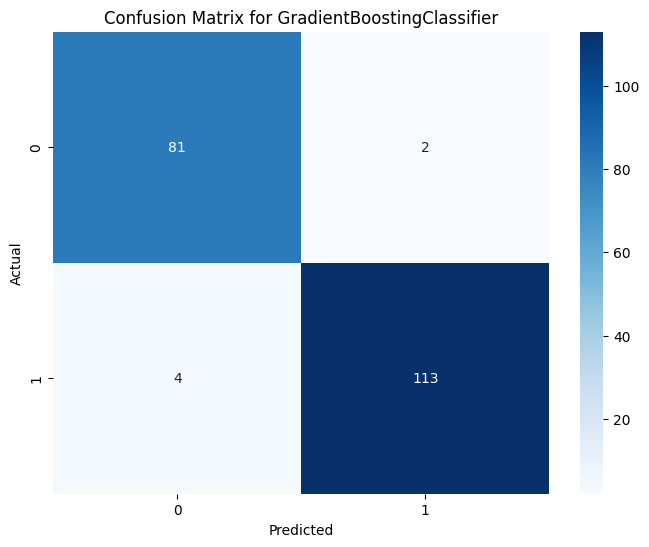

Accuracy: 0.9700
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        83
           1       0.98      0.97      0.97       117

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200


With Relief Feature Selection:


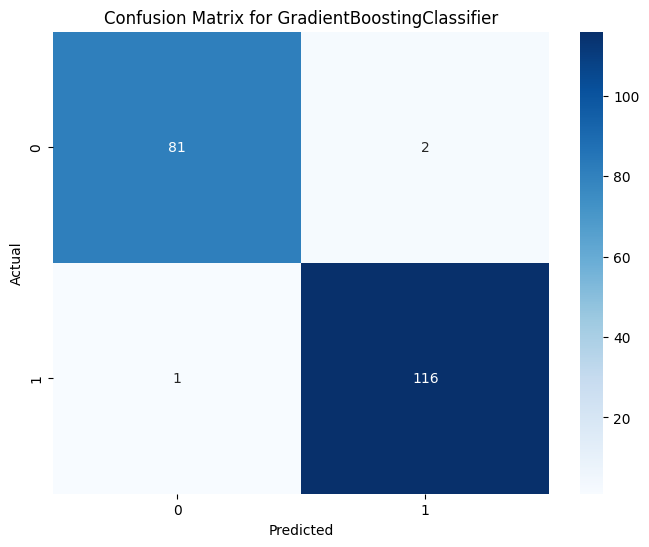

Accuracy: 0.9850
              precision    recall  f1-score   support

           0       0.99      0.98      0.98        83
           1       0.98      0.99      0.99       117

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200


With LASSO Feature Selection:


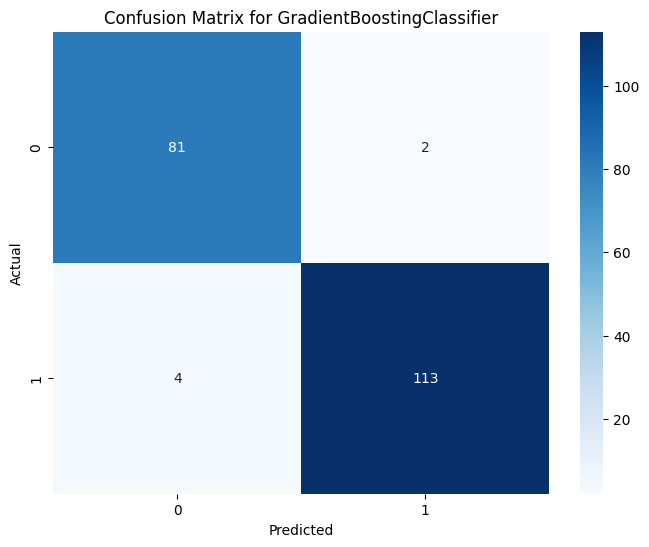

Accuracy: 0.9700
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        83
           1       0.98      0.97      0.97       117

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



In [22]:
# Evaluate Gradient Boosting
print("\nGradient Boosting")
print("Without Feature Selection:")
accuracy, report, _ = evaluate_model(gradient_boosting, X_train_scaled, X_test_scaled, y_train, y_test,"NoFS")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies.append(("Gradient Boosting", accuracy))
print(report)

print("\nWith Relief Feature Selection:")
accuracy, report, _ = evaluate_model(gradient_boosting, X_train_relief, X_test_relief, y_train, y_test,"Relief")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_relief.append(("Gradient Boosting", accuracy))
print(report)

print("\nWith LASSO Feature Selection:")
accuracy, report, _ = evaluate_model(gradient_boosting, X_train_lasso, X_test_lasso, y_train, y_test,"LASSO")
print(f"Accuracy: {accuracy:.4f}")
model_accuracies_lasso.append(("Gradient Boosting", accuracy))
print(report)

(0.965, 0.98, 0.935, 0.975, 0.97)


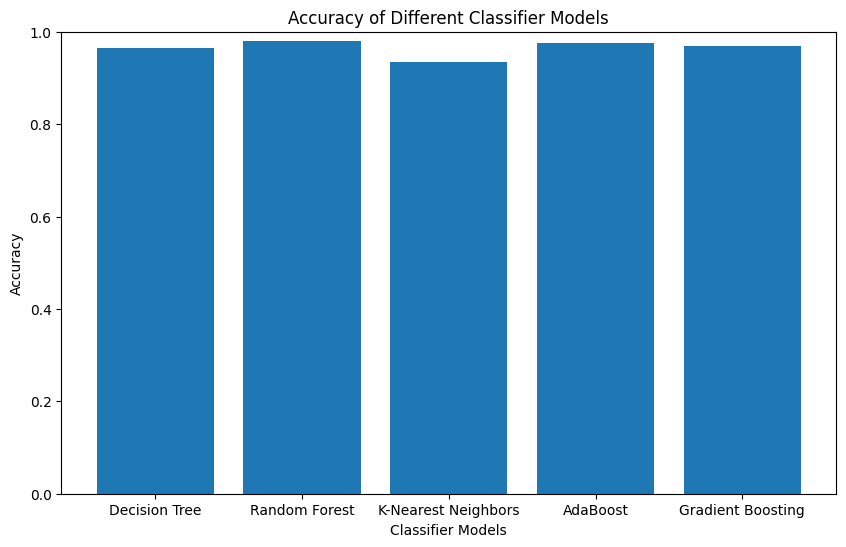

In [23]:
models, accuracies = zip(*model_accuracies)

print(accuracies)
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.xlabel('Classifier Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifier Models')
plt.ylim(0, 1)  # To ensure the y-axis is in the range 0 to 1
plt.savefig('Accuracy_Without_FS.svg', format='svg', bbox_inches='tight')
plt.show()

(0.965, 0.98, 0.955, 0.97, 0.985)


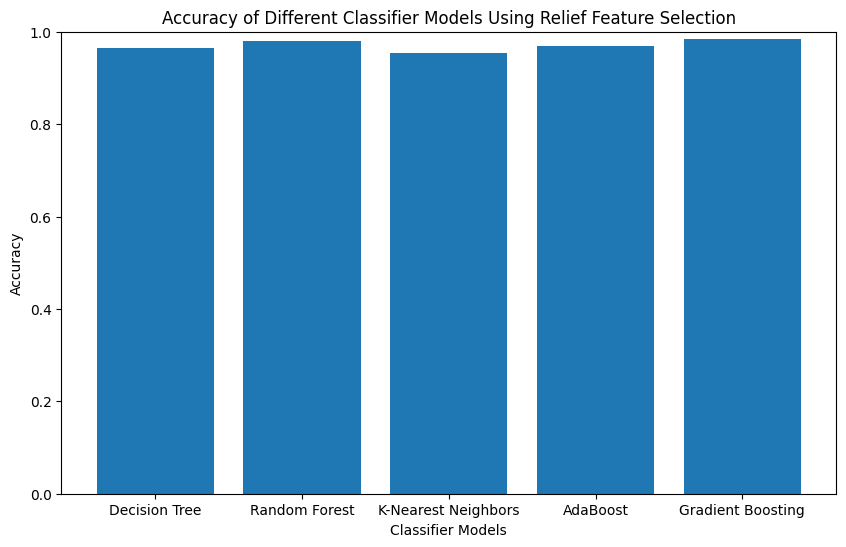

In [24]:
models, accuracies = zip(*model_accuracies_relief)

print(accuracies)
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.xlabel('Classifier Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifier Models Using Relief Feature Selection')
plt.ylim(0, 1)  # To ensure the y-axis is in the range 0 to 1
plt.savefig('Accuracy_With_Relief_FS.svg', format='svg', bbox_inches='tight')
plt.show()

(0.96, 0.985, 0.96, 0.975, 0.97)


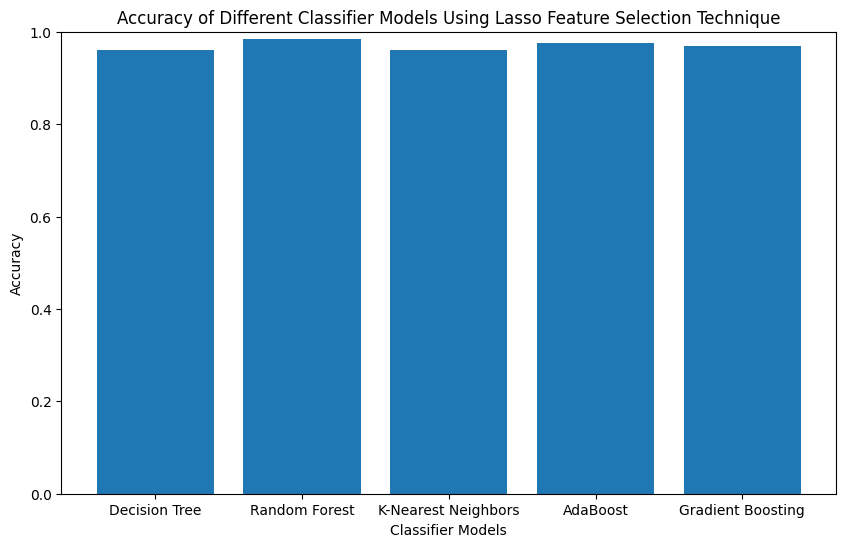

In [25]:
models, accuracies = zip(*model_accuracies_lasso)

print(accuracies)
# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.xlabel('Classifier Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Classifier Models Using Lasso Feature Selection Technique')
plt.ylim(0, 1)  # To ensure the y-axis is in the range 0 to 1
plt.savefig('Accuracy_With_Lasso_FS.svg', format='svg', bbox_inches='tight')
plt.show()